## Main Jupyter Notebooks for implementing the German Traffic Sign Classification CNN

# Read in Data

In [ ]:
# Imports 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

In [ ]:
# Gibt an, ob wir auf einer GPU oder CPU trainieren 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# Hier wird unser mean und unser std für die Normalisierung der Bilder berechnet
# dataset = ImageFolder("GTSRB\Final_Training\Images", transform=transforms.ToTensor())
transform_mean_std = transforms.Compose([
    transforms.Resize((35, 35)),  
    transforms.ToTensor(),
])
dataset = ImageFolder("C:/Users/v814u63/Documents/Uni/5. Semester/XAI/images/train_images", transform=transform_mean_std)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean = 0.
std = 0.
total_images_count = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_samples

mean /= total_images_count
std /= total_images_count

print(f"Mean: {mean}")
print(f"Std: {std}")


In [ ]:
# transform definieren zum Einlesen der Test- und Trainingsdaten
img_size = 35 
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()) 
])

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(20),  # Zufällige Rotation um ±20 Grad
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),  # Zufälliges Zuschneiden und Skalieren
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Helligkeit und Farbvariation
    transforms.RandomHorizontalFlip(),  # Zufälliges horizontales Spiegeln
    transforms.ToTensor(),  # Umwandlung zu einem Tensor
    transforms.Normalize(mean.tolist(), std.tolist())  # Normalisierung
])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2166791..4.2980943].


    Index                            Label
0       0                          100_kmh
1       1                          120_kmh
2       2                           20_kmh
3       3                           30_kmh
4       4                           50_kmh
5       5                           60_kmh
6       6                           70_kmh
7       7                    80_aufgehoben
8       8                           80_kmh
9       9                      achtung_eis
10     10                  achtung_fahrrad
11     11                   achtung_kinder
12     12              achtung_wildwechsel
13     13                            ampel
14     14                        baustelle
15     15              durchfahrt_verboten
16     16               einmalige_vorfahrt
17     17                      fussgaenger
18     18                   gefahrenstelle
19     19                     kreisverkehr
20     20               lkw_ueberholverbot
21     21    lkw_ueberholverbot_aufgehoben
22     22  

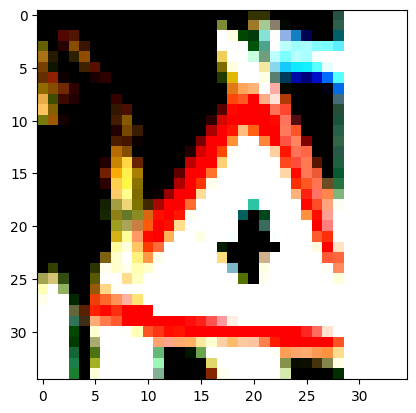

In [154]:
import pandas as pd

# Einlesen der Datasets
train_dataset = ImageFolder(root='GTSRB\Final_Test\Images', transform=transform)
train_transforms_dataset = ImageFolder(root='GTSRB\Final_Test\Images', transform=train_transforms)

test_dataset = ImageFolder(root='GTSRB\Final_Training\Images', transform=transform)

# Erstellen einer Tabelle, die den Index und das zugehörige Label zeigt
label_dict = {index: label for index, label in enumerate(train_dataset.classes)}

# Konvertiere das Dictionary in einen DataFrame für eine saubere Darstellung
df = pd.DataFrame(list(label_dict.items()), columns=['Index', 'Label'])
print(df)

# Wenn du das Bild und das Label zur Überprüfung anzeigen willst
img, label = train_dataset[4000]
label_string = test_dataset.classes[label]
print("Label:", label_string)
plt.imshow(img.permute(1, 2, 0))
plt.show()


# Create the Model


In [ ]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Convolutional Layers
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)

        # Dynamische Berechnung der FC-Eingabegröße
        self.flatten = nn.Flatten()
        dummy_input = torch.zeros(batch_size, 3, img_size, img_size)  # Dummy-Eingabe mit typischer Größe (z.B. 224x224)
        fc_input_size = self._get_fc_input_size(dummy_input)

        # Fully Connected Layers
        self.fc6 = nn.Linear(fc_input_size, 512)
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()

        self.fc9 = nn.Linear(128, num_classes)

    def _get_fc_input_size(self, dummy_input):
        """Hilfsfunktion, um die Eingabegröße für die Fully Connected Layers zu berechnen."""
        with torch.no_grad():
            x = self.conv_layer1(dummy_input)
            x = self.relu1(x)
            x = self.max_pool1(x)

            x = self.conv_layer2(x)
            x = self.relu2(x)
            x = self.max_pool2(x)

            x = self.conv_layer3(x)
            x = self.relu3(x)

            x = self.conv_layer4(x)
            x = self.relu4(x)

            x = self.conv_layer5(x)
            x = self.relu5(x)
            x = self.max_pool5(x)

            x = self.flatten(x)  # Flatten the output
        return x.size(1)  # Gib die Anzahl der Features zurück

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = self.flatten(out)  # Flatten
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out


### Different CNN Model

In [ ]:
# Anderes CNN definieren zum Testen
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(64 * 7 * 7, 750) 
        self.bn5 = nn.BatchNorm1d(750)
        self.dropout2 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(750, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, 43)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(self.bn3(x))
        
        x = F.relu(self.bn4(self.conv3(x)))
        x = self.pool2(x)
        x = self.dropout1(x)
        
        x = self.flatten(x)
        
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.dropout3(x)
        
        x = F.softmax(self.fc3(x), dim=1)
        return x


# Training

### Initialization of the model and definition of hyperparameters


In [ ]:
# Initialisierung des Modells
model = CNN(num_classes).to(device)
loss_func = nn.CrossEntropyLoss()

# Initiale Lernrate und Optimizer
lr = 0.01
weight_decay = 0.001
#optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = optim.SGD(model.parameters(), lr=lr)

# ReduceLROnPlateau Scheduler
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.001)

### Calculate Accuracy Function

In [ ]:
def training_loop(lr, weight_decay, threshold):
    # Initialisierung des Modells
    model = CNN(num_classes).to(device)
    loss_func = nn.CrossEntropyLoss()

    # Initiale Lernrate und Optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # ReduceLROnPlateau Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=threshold, verbose=True)
    return model, loss_func, optimizer, scheduler

### Calculate Accuracy Function

In [ ]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

### Default Training

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save model
torch.save(model.state_dict(), 'model/new_cnn_architecture.pth')

### Test model with accuracy plot

#### Get the Activation of the Model Layers 

In [ ]:
# Dictionary to store activations
activations = {}

# Hook function to capture the outputs
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Initialize the model
model = CNN(num_classes=43)
model.to(device)
# Initiale Lernrate und Optimizer
loss_func = nn.CrossEntropyLoss()
lr = 0.01
weight_decay = 0.001
# optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Register hooks to capture activations from convolutional and fully connected layers
model.conv_layer1.register_forward_hook(get_activation('conv_layer1'))
model.conv_layer2.register_forward_hook(get_activation('conv_layer2'))
model.conv_layer3.register_forward_hook(get_activation('conv_layer3'))
model.conv_layer4.register_forward_hook(get_activation('conv_layer4'))
model.conv_layer5.register_forward_hook(get_activation('conv_layer5'))

# Register hooks for ReLU activations
model.relu1.register_forward_hook(get_activation('relu1'))
model.relu2.register_forward_hook(get_activation('relu2'))
model.relu3.register_forward_hook(get_activation('relu3'))
model.relu4.register_forward_hook(get_activation('relu4'))
model.relu5.register_forward_hook(get_activation('relu5'))

# Register hooks for fully connected layers
model.fc6.register_forward_hook(get_activation('fc6'))
model.fc7.register_forward_hook(get_activation('fc7'))
model.fc8.register_forward_hook(get_activation('fc8'))
model.fc9.register_forward_hook(get_activation('fc9'))

# Register hooks for ReLU activations in fully connected layers
model.relu6.register_forward_hook(get_activation('relu6'))
model.relu7.register_forward_hook(get_activation('relu7'))
model.relu8.register_forward_hook(get_activation('relu8'))


### More Visualization while Training 

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Zusätzliche Listen für neue Visualisierungen
last_layer_weights = []
pca_results = []

num_epochs = 100
train_accuracies = []
test_accuracies = []
train_losses = []

# Initialize the plots
plt.figure(figsize=(12, 8))

# Variable für Loader-Wechsel
current_loader = train_loader
previous_loss = float('inf')
switch_epoch = None  # Speichert die Epoche des Loaderswechsels

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0  # Track the loss for the current epoch

    for i, (images, labels) in enumerate(current_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = loss_func(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the current epoch
    avg_loss = running_loss / len(current_loader)

    # Accuracy on training and test data
    train_accuracy = calculate_accuracy(model, current_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(avg_loss)

    print(f"Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Check if loss has increased and Loader hasn't switched yet
    if avg_loss > previous_loss and current_loader == train_loader:
        print("Loss has increased. Switching to train_transforms_loader.")
        current_loader = train_transforms_loader  # Wechsel zu transformiertem Loader
        switch_epoch = epoch  # Speichere die Epoche des Wechsels
        print("Training will continue for exactly 10 epochs after loader switch.")

    # Update the previous loss
    previous_loss = avg_loss

    # Visualisierung der Gewichte der letzten Schicht (vor dem Output Layer)
    last_fc_weights = model.fc9.weight.data.cpu().numpy()  # Anpassen, falls die Schicht anders heißt
    last_layer_weights.append(last_fc_weights)

    # PCA auf die Output-Vektoren anwenden
    with torch.no_grad():
        pca = PCA(n_components=2)
        outputs_2d = pca.fit_transform(outputs.cpu().numpy())
    pca_results.append(outputs_2d)

    # Visualisierungen aktualisieren
    plt.clf()  # Clear the figure
    plt.figure(figsize=(12, 8))
    # Plot 1: Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot 2: Loss
    plt.subplot(2, 2, 2)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot 3: PCA der Outputs
    plt.subplot(2, 2, 3)
    plt.scatter(outputs_2d[:, 0], outputs_2d[:, 1], c=labels.cpu().numpy(), cmap='viridis', s=10)
    plt.colorbar(label='Class Index')
    plt.title('PCA of Output Vectors')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')

    # Plot 4: Visualisierung der letzten Layer-Gewichte
    plt.subplot(2, 2, 4)
    plt.imshow(last_fc_weights, cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.title('Weights of Last FC Layer')
    plt.xlabel('Neurons')
    plt.ylabel('Classes')

    if switch_epoch is not None and epoch >= switch_epoch + 10:
            print(f"Stopping training after 10 epochs post-switch at epoch {epoch + 1}.")
            plt.savefig(f'model/optim_loop/RMSprop/train_{train_accuracy}_test_{test_accuracy}.png')
            break

    # Display the updated plot
    plt.tight_layout()
    plt.pause(0.1)

# Save the model's weights
torch.save(model.state_dict(), f'model/gute_modell.pth')
torch.save(model.state_dict(), f'model/optim_loop/RMSprop/train_{train_accuracy}_test_{test_accuracy}.pth')

# Show the final plot after all epochs
plt.show()


#### Same with TSNE

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch

# Zusätzliche Listen für neue Visualisierungen
last_layer_weights = []
tsne_results = []

num_epochs = 100
train_accuracies = []
test_accuracies = []
train_losses = []

# Initialize the plots
plt.figure(figsize=(12, 8))

# Variable für Loader-Wechsel
current_loader = train_loader
previous_loss = float('inf')
switch_epoch = None  # Speichert die Epoche des Loaderswechsels

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0  # Track the loss for the current epoch

    for i, (images, labels) in enumerate(current_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = loss_func(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the current epoch
    avg_loss = running_loss / len(current_loader)

    # Accuracy on training and test data
    train_accuracy = calculate_accuracy(model, current_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(avg_loss)

    print(f"Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Check if loss has increased and Loader hasn't switched yet
    if avg_loss > previous_loss and current_loader == train_loader:
        print("Loss has increased. Switching to train_transforms_loader.")
        current_loader = train_transforms_loader  # Wechsel zu transformiertem Loader
        switch_epoch = epoch  # Speichere die Epoche des Wechsels
        print("Training will continue for exactly 10 epochs after loader switch.")

    # Update the previous loss
    previous_loss = avg_loss

    # Visualisierung der Gewichte der letzten Schicht (vor dem Output Layer)
    last_fc_weights = model.fc9.weight.data.cpu().numpy()  # Anpassen, falls die Schicht anders heißt
    last_layer_weights.append(last_fc_weights)

    # t-SNE auf die Output-Vektoren anwenden
    with torch.no_grad():
        tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
        outputs_2d = tsne.fit_transform(outputs.cpu().numpy())
    tsne_results.append(outputs_2d)

    # Visualisierungen aktualisieren
    plt.clf()  # Clear the figure
    plt.figure(figsize=(12, 8))
    # Plot 1: Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot 2: Loss
    plt.subplot(2, 2, 2)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot 3: t-SNE der Outputs
    plt.subplot(2, 2, 3)
    plt.scatter(outputs_2d[:, 0], outputs_2d[:, 1], c=labels.cpu().numpy(), cmap='viridis', s=10)
    plt.colorbar(label='Class Index')
    plt.title('t-SNE of Output Vectors')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')

    # Plot 4: Visualisierung der letzten Layer-Gewichte
    plt.subplot(2, 2, 4)
    plt.imshow(last_fc_weights, cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.title('Weights of Last FC Layer')
    plt.xlabel('Neurons')
    plt.ylabel('Classes')

    if switch_epoch is not None and epoch >= switch_epoch + 10:
        print(f"Stopping training after 10 epochs post-switch at epoch {epoch + 1}.")
        plt.savefig(f'model/optim_loop/RMSprop/train_{train_accuracy}_test_{test_accuracy}.png')
        break

    # Display the updated plot
    plt.tight_layout()
    plt.pause(0.1)

# Save the model's weights
torch.save(model.state_dict(), f'model/gute_modell.pth')
torch.save(model.state_dict(), f'model/optim_loop/RMSprop/train_{train_accuracy}_test_{test_accuracy}.pth')

# Show the final plot after all epochs
plt.show()


### Train Code from yt 
(https://www.youtube.com/watch?v=ZBfpkepdZlw)

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
		# load in the data in batches
    for i, (images, labels) in enumerate(train_loader):  
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # forward propagation
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        # backward propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # at end of epoch check validation loss and acc
    with torch.no_grad():
      	# switch model to eval (not train) model
        model.eval()
        correct = 0
        total = 0
        all_val_loss = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            total += labels.size(0)
            # calculate predictions
            predicted = torch.argmax(outputs, dim=1)
            # calculate actual values
            correct += (predicted == labels).sum().item()
            # calculate the loss
            all_val_loss.append(loss_func(outputs, labels).item())
        # calculate val-loss
        mean_val_loss = sum(all_val_loss) / len(all_val_loss)
        # calculate val-accuracy
        mean_val_acc = 100 * (correct / total)
    print(
        'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
            epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_acc
        )
    )

# Test the Model

### Test the current Model

In [ ]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")

#torch.save(model.state_dict(), "model/good_models/99_95_and_95_77/training_99_95_test_95_77.pth")


### Calculate Accuracy per Class

In [ ]:
import torch
import matplotlib.pyplot as plt

# Berechnet die Accuracy pro Klasse, ohne die Anzahl der Klassen als Eingabe zu benötigen
def calculate_class_accuracy(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Sammle die Richtigkeit der Vorhersagen für jede Klasse
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names

# Berechne und plotte die Klassenaccuracy nach den 40 Trainingsepochen
class_accuracies, class_names = calculate_class_accuracy(trained_model, test_loader, device)

# Plot Histogramm der Klassenaccuracies mit Klassennamen auf der x-Achse
plt.figure(figsize=(12, 8))
plt.bar(range(len(class_names)), class_accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Class after Training')
plt.xticks(range(len(class_names)), class_names, rotation=90)  # Setzt die Klassennamen als x-Achsen-Beschriftungen
plt.grid(axis='y')
plt.show()


### Calculate Accuracy per Class and save wrong Predictions

In [ ]:
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# Berechnet die Accuracy pro Klasse und speichert falsche Vorhersagen
def calculate_class_accuracy_and_misclassifications(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    misclassified_counts = defaultdict(lambda: [0] * num_classes)  # Zählt Fehlklassifizierungen je Klasse
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Zählt korrekte und fehlerhafte Vorhersagen
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
                else:
                    misclassified_counts[label][predicted[i].item()] += 1  # Fehlklassifizierung speichern
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names, misclassified_counts

# Berechne Accuracy und Fehlklassifizierungen
class_accuracies, class_names, misclassified_counts = calculate_class_accuracy_and_misclassifications(trained_model, test_loader, device)

# Erstelle Plots für Klassen mit einer Accuracy < 80%
for i, accuracy in enumerate(class_accuracies):
    if accuracy < 80:
        # Bereite Daten für die Fehlklassifizierungen dieser Klasse auf
        misclassified_counts_for_class = misclassified_counts[i]
        misclassified_class_names = [class_names[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        misclassified_class_counts = [misclassified_counts_for_class[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        
        # Plot der Fehlklassifizierungen für die Klasse
        plt.figure(figsize=(8, 5))
        plt.bar(misclassified_class_names, misclassified_class_counts, color='salmon')
        plt.xlabel('Predicted Class')
        plt.ylabel('Count')
        plt.title(f"Misclassifications for Class '{class_names[i]}' (Accuracy: {accuracy:.2f}%)")
        plt.xticks(rotation=90)
        plt.grid(axis='y')
        plt.show()


### If you want to test an old model, you can do this right here

Define the CNN Model Class vor Evaluation. Make sure you replace this with the correct Conv Layers and FC Layers of your trained model. 

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes, image_size = 35):
        super(Net, self).__init__()
        # Convolutional Layers
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)

        # Dynamische Berechnung der FC-Eingabegröße
        self.flatten = nn.Flatten()
        dummy_input = torch.zeros(batch_size, 3, image_size, image_size)  # Dummy-Eingabe mit typischer Größe (z.B. 224x224)
        fc_input_size = self._get_fc_input_size(dummy_input)

        # Fully Connected Layers
        self.fc6 = nn.Linear(fc_input_size, 512)
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()

        self.fc9 = nn.Linear(128, num_classes)

    def _get_fc_input_size(self, dummy_input):
        """Hilfsfunktion, um die Eingabegröße für die Fully Connected Layers zu berechnen."""
        with torch.no_grad():
            x = self.conv_layer1(dummy_input)
            x = self.relu1(x)
            x = self.max_pool1(x)

            x = self.conv_layer2(x)
            x = self.relu2(x)
            x = self.max_pool2(x)

            x = self.conv_layer3(x)
            x = self.relu3(x)

            x = self.conv_layer4(x)
            x = self.relu4(x)

            x = self.conv_layer5(x)
            x = self.relu5(x)
            x = self.max_pool5(x)

            x = self.flatten(x)  # Flatten the output
        return x.size(1)  # Gib die Anzahl der Features zurück

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = self.flatten(out)  # Flatten
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out


Provide now informations such as path and the number of output classes

In [240]:
import torch
import os
from torchvision import transforms
from PIL import Image

# Bildpfad angeben
image_path = 'GTSRB\Final_Test\Images\\50_kmh\\00092.ppm'  # Hier den Pfad zum Bild angeben

# Prüfen, ob der Modellpfad existiert
model_path = 'model\FINAL_Models\RMSprop_FINAL_image_size_35_train_92.55273024050601_test_92.95508869040131.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Das Modell unter '{model_path}' wurde nicht gefunden.")

# Dictionary für die Aktivierungen
activations = {}

# Hook-Funktion, um die Ausgaben zu speichern
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Initialisierung des Modells
trained_model = Net(num_classes=43)
trained_model.to(device)

# Modell laden
trained_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Hooks für die Schichten des Modells registrieren
trained_model.conv_layer1.register_forward_hook(get_activation('conv_layer1'))
trained_model.conv_layer2.register_forward_hook(get_activation('conv_layer2'))
trained_model.conv_layer3.register_forward_hook(get_activation('conv_layer3'))
trained_model.conv_layer4.register_forward_hook(get_activation('conv_layer4'))
trained_model.conv_layer5.register_forward_hook(get_activation('conv_layer5'))

# Hooks für die ReLU-Schichten registrieren
trained_model.relu1.register_forward_hook(get_activation('relu1'))
trained_model.relu2.register_forward_hook(get_activation('relu2'))
trained_model.relu3.register_forward_hook(get_activation('relu3'))
trained_model.relu4.register_forward_hook(get_activation('relu4'))
trained_model.relu5.register_forward_hook(get_activation('relu5'))

# Hooks für Fully-Connected-Schichten registrieren
trained_model.fc6.register_forward_hook(get_activation('fc6'))
trained_model.fc7.register_forward_hook(get_activation('fc7'))
trained_model.fc8.register_forward_hook(get_activation('fc8'))
trained_model.fc9.register_forward_hook(get_activation('fc9'))

# Hooks für ReLU in Fully-Connected-Schichten registrieren
trained_model.relu6.register_forward_hook(get_activation('relu6'))
trained_model.relu7.register_forward_hook(get_activation('relu7'))
trained_model.relu8.register_forward_hook(get_activation('relu8'))

# Bildvorverarbeitung definieren
transform = transforms.Compose([
    transforms.Resize((35, 35)),  # Größe anpassen
    transforms.ToTensor(),       # In Tensor umwandeln
    transforms.Normalize(mean=mean, std=std)  # Normalisierung
])

# Test Forward-Pass mit Bild
if __name__ == "__main__":
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Das Bild unter '{image_path}' wurde nicht gefunden.")
    
    # Bild laden und vorverarbeiten
    image = Image.open(image_path).convert('RGB')  # Bild in RGB umwandeln
    image = transform(image).unsqueeze(0)         # Batch-Dimension hinzufügen
    
    # Bild durch das Modell leiten
    image = image.to(device)
    output = trained_model(image)
    
    print("Forward-Pass abgeschlossen.")
    print("Gespeicherte Aktivierungen:", activations.keys())


Forward-Pass abgeschlossen.
Gespeicherte Aktivierungen: dict_keys(['conv_layer1', 'relu1', 'conv_layer2', 'relu2', 'conv_layer3', 'relu3', 'conv_layer4', 'relu4', 'conv_layer5', 'relu5', 'fc6', 'relu6', 'fc7', 'relu7', 'fc8', 'relu8', 'fc9'])


C:\Users\v814u63\AppData\Local\Temp\ipykernel_21952\1316993345.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model_path, map_

Now you can test your new model

In [ ]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
trained_model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(trained_model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(trained_model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")

# Visualisation and Explainable Part 

In [ ]:
# Get a batch of test images
images, labels = next(iter(test_loader))

# Select a random or specific image by changing the index
rand = 9  # Ändere die Zahl hier, um ein anderes Bild anzuzeigen
image = images[rand:rand+1]
label = labels[rand]
image = image.to(device)
label = label.to(device)

# Display the input image
plt.imshow(image[0].permute(1, 2, 0).cpu())  # Bild vom Tensor in NumPy-Format umwandeln
plt.title(f'Input Image - Label: {label.item()}')
plt.axis('off')
plt.show()


In [ ]:
# Eingabebild (Beispiel)
image = torch.randn(1, 3, 35, 35).to(device)  # Simuliertes Bild (Batch-Größe 1)

# Reset des Aktivierungs-Dictionaries
activations = {}

# Forward-Pass
output = trained_model(image)

# Gespeicherte Aktivierungen ausgeben
print("Gespeicherte Aktivierungen:", activations.keys())
for layer, activation in activations.items():
    print(f"{layer}: {activation.shape}")

Shape of conv1 activations: torch.Size([1, 64, 34, 34])


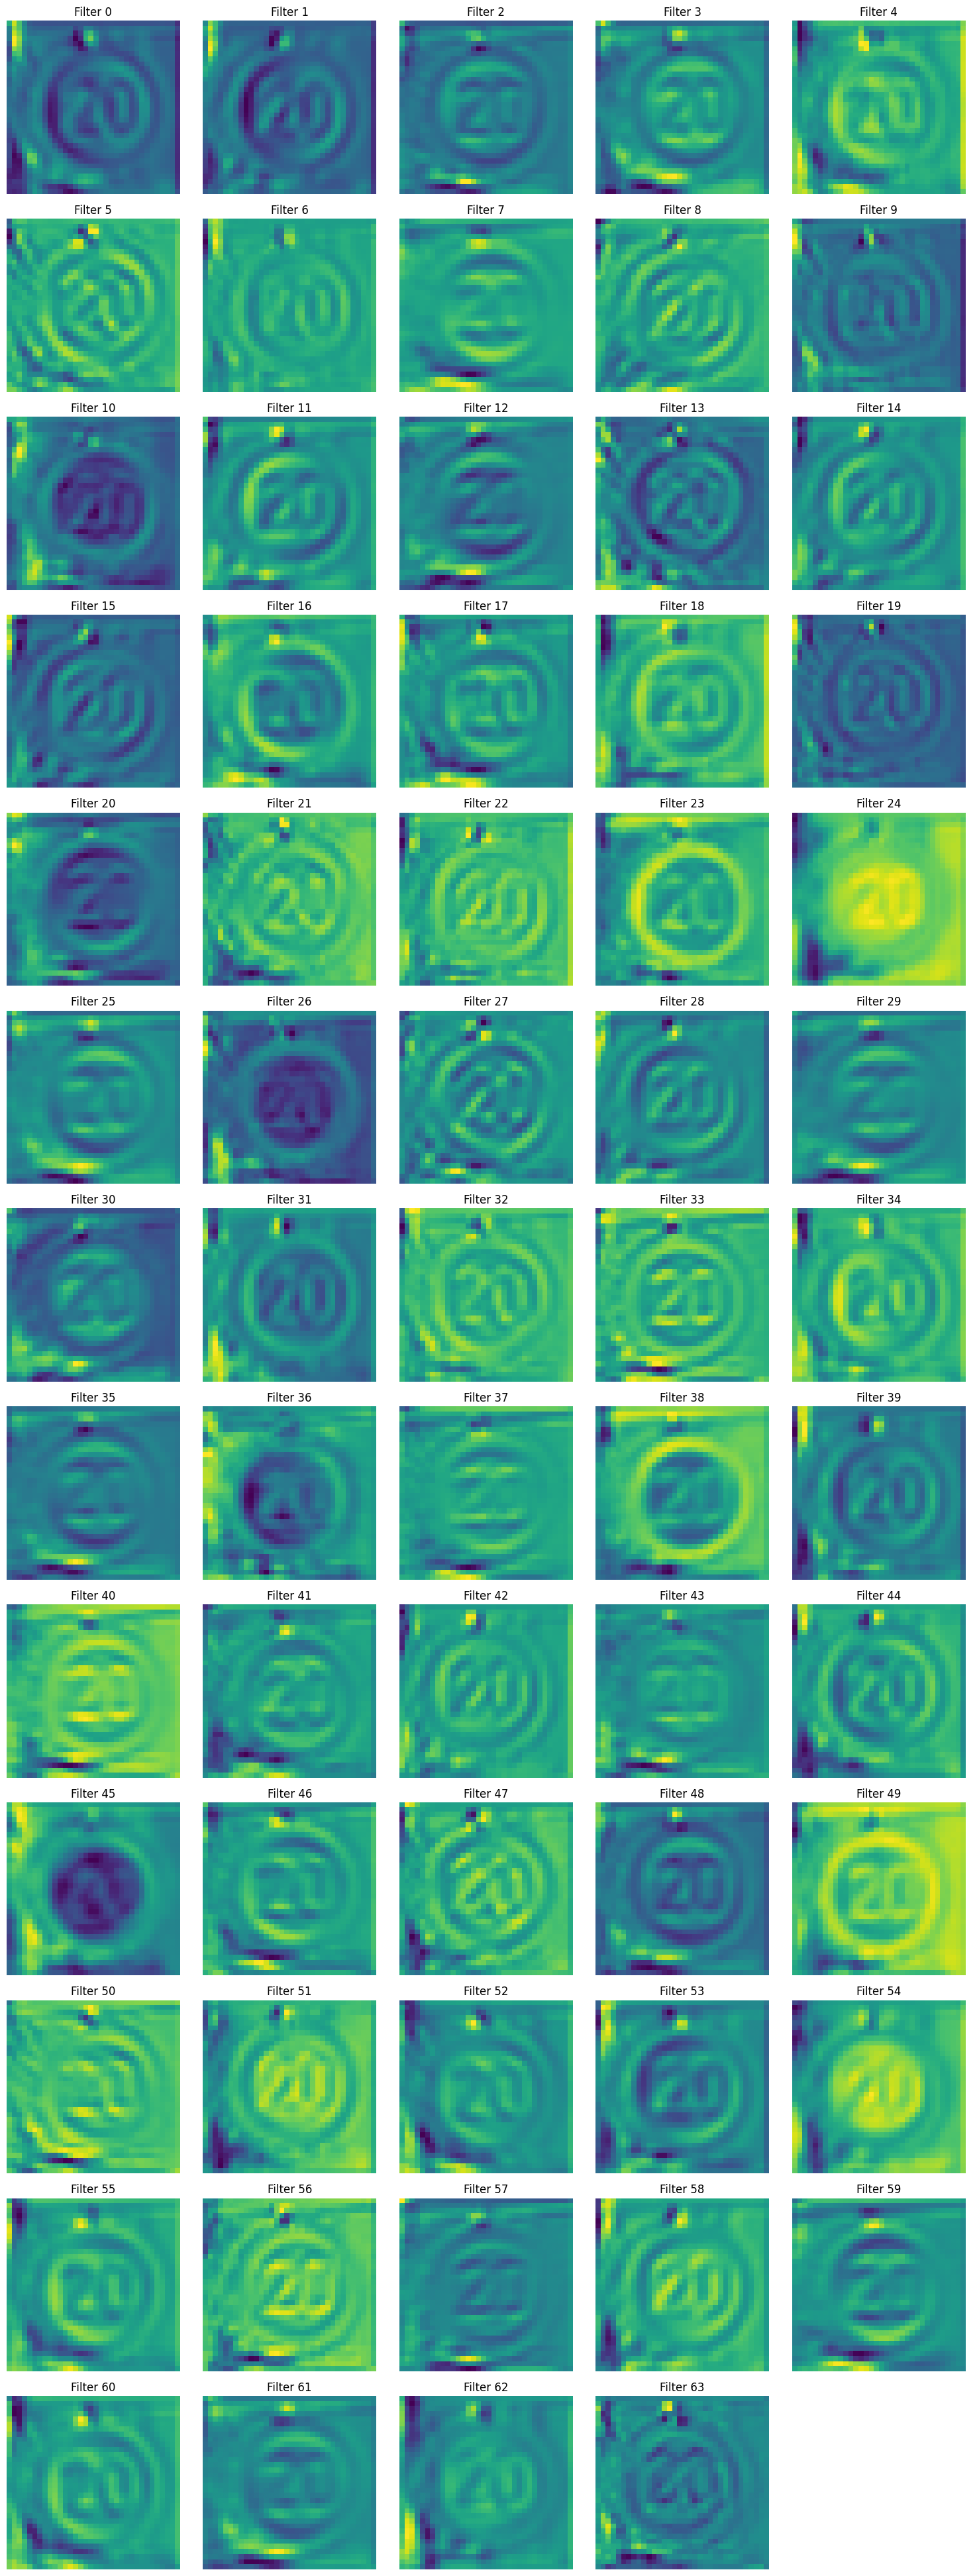

In [236]:
import math
import matplotlib.pyplot as plt

# Aktivierungen abrufen
act = activations['conv_layer1']
print(f"Shape of conv1 activations: {act.shape}")

# Filter-Anzahl
num_filters = act.shape[1]

# Dynamische Subplots
rows = math.ceil(num_filters / 5)
fig, axes = plt.subplots(rows, 5, figsize=(15, rows * 3))

for idx in range(num_filters):
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(act[0, idx].detach().cpu(), cmap='viridis')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Filter {idx}')

# Unbenutzte Subplots entfernen (falls nötig)
for idx in range(num_filters, rows * 5):
    row = idx // 5
    col = idx % 5
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


### Activation Maximazation

In [223]:
def activation_maximization(model, layer_name, filter_index, input_size=(1, 3, 35, 35), lr=0.1, iterations=30):
    device = next(model.parameters()).device  # Gerät des Modells (CPU oder GPU)
    
    # Initialisierung der Eingabe
    input_image = torch.randn(input_size, requires_grad=True, device=device)  # Auf das richtige Gerät legen
    
    optimizer = optim.RMSprop([input_image], lr=lr, weight_decay=1e-6)
    activations = {}

    # Hook-Funktion für die gewünschte Schicht
    def hook_function(module, input, output):
        activations[layer_name] = output

    # Hook registrieren
    layer = dict(model.named_modules())[layer_name]
    hook = layer.register_forward_hook(hook_function)

    for i in range(iterations):
        optimizer.zero_grad()
        model(input_image)  # Modell auf dem richtigen Gerät ausführen
        act = activations[layer_name][0, filter_index]
        loss = -torch.mean(act)  # Aktivierung maximieren
        loss.backward()
        optimizer.step()
        # Eingabewerte beschränken
        input_image.data = torch.clamp(input_image.data, 0, 1)
        # if (i + 1) % 10 == 0:
        #     print(f"Iteration {i+1}/{iterations}, Loss: {-loss.item():.4f}")

    hook.remove()
    return input_image.detach()


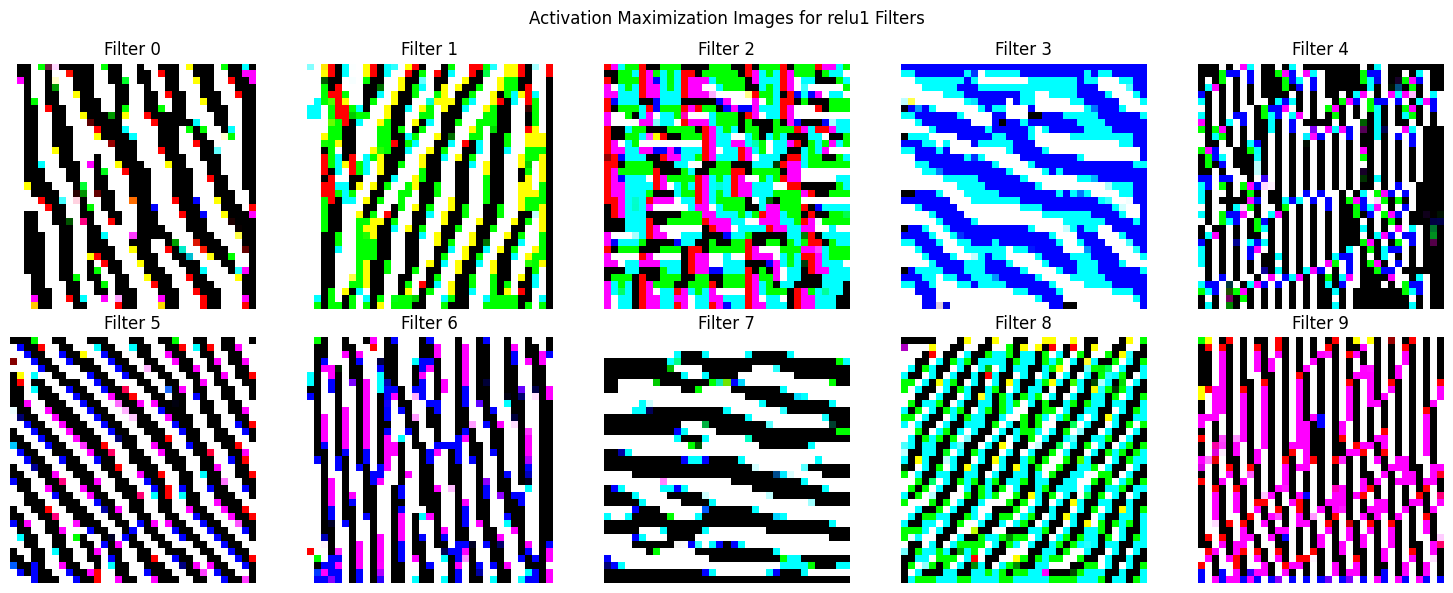

In [224]:
conv_layer1num_filters_relu1 = trained_model.conv_layer1.out_channels
am_images_relu1 = []

for filter_idx in range(conv_layer1num_filters_relu1):
    #print(f"\nGenerating image for relu1 filter {filter_idx}")
    am_image = activation_maximization(trained_model, 'relu1', filter_idx, input_size=(1, 3, 35, 35), lr=0.1, iterations=30)
    am_images_relu1.append(am_image)

#print("\nCompleted activation maximization for relu1.")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, am_image in enumerate(am_images_relu1[:10]):  # Maximal 10 Bilder anzeigen
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(am_image.squeeze().permute(1, 2, 0).cpu().numpy())  # RGB-Bild darstellen
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Filter {idx}')

plt.suptitle('Activation Maximization Images for relu1 Filters')
plt.tight_layout()
plt.show()


In [ ]:
# ReLu 2

# Anzahl der Filter in der zweiten Schicht (ReLU2)
conv_layer2num_filters_relu2 = trained_model.conv_layer2.out_channels
am_images_relu2 = []

# Aktivierungsmaximierung für alle Filter der ReLU2-Schicht
for filter_idx in range(conv_layer2num_filters_relu2):
    #print(f"\nGenerating image for relu2 filter {filter_idx}")
    am_image = activation_maximization(
        trained_model, 'relu2', filter_idx, input_size=(1, 3, 35, 35), lr=0.1, iterations=30
    )
    am_images_relu2.append(am_image)

print("\nCompleted activation maximization for relu2.")

# Darstellung der Ergebnisse
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Layout für 10 Filter

for idx, am_image in enumerate(am_images_relu2[:10]):  # Maximal 10 Bilder anzeigen
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(am_image.squeeze().permute(1, 2, 0).cpu().numpy())  # RGB-Bild
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Filter {idx}')

plt.suptitle('Activation Maximization Images for relu2 Filters')
plt.tight_layout()
plt.show()


C:\Users\v814u63\AppData\Local\Temp\ipykernel_21952\3247780429.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model_path, map_

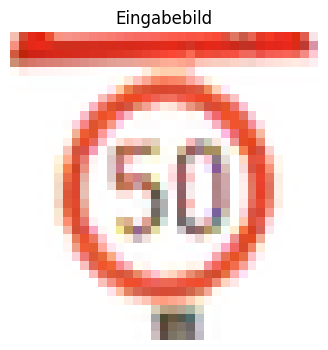

Shape der Aktivierung nach ReLU1: torch.Size([1, 64, 34, 34])
Shape von Filter 0: (34, 34)
Shape von Filter 1: (34, 34)
Shape von Filter 2: (34, 34)
Shape von Filter 3: (34, 34)
Shape von Filter 4: (34, 34)
Shape von Filter 5: (34, 34)
Shape von Filter 6: (34, 34)
Shape von Filter 7: (34, 34)
Shape von Filter 8: (34, 34)
Shape von Filter 9: (34, 34)


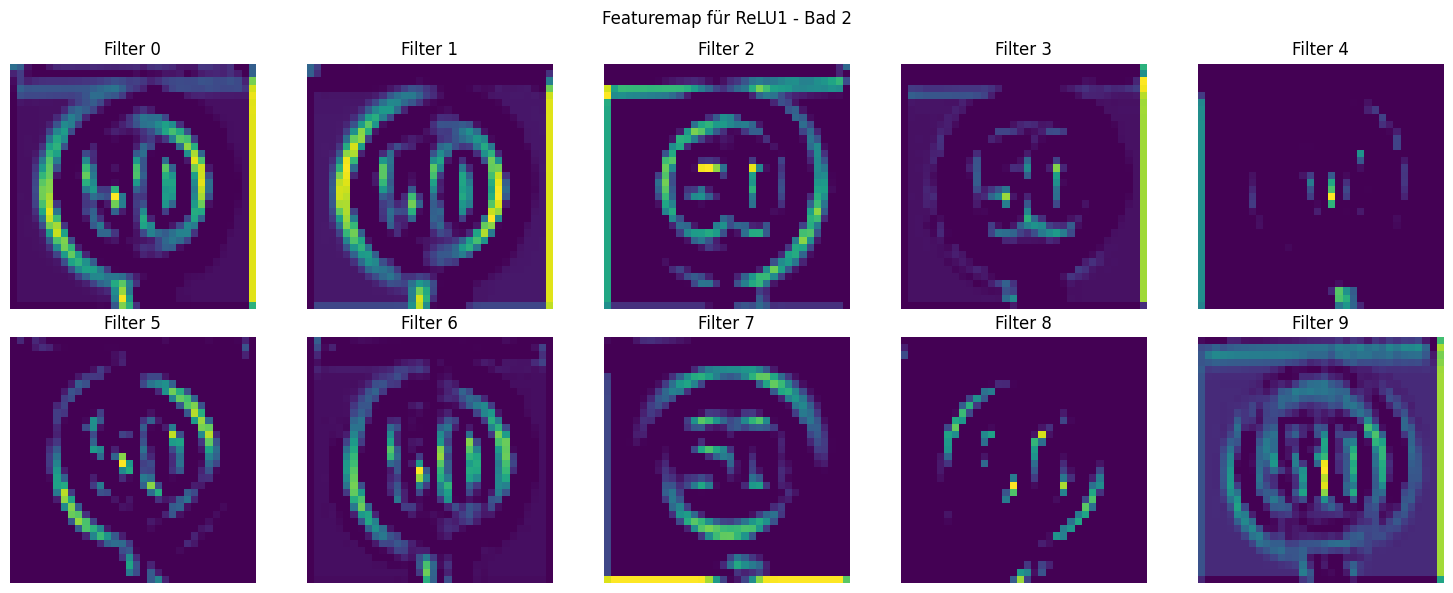

In [241]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms


# Modell und Gerät (z.B. CPU oder GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Bildvorverarbeitung definieren
transform = transforms.Compose([
    transforms.Resize((35, 35)),  # Größe anpassen, z.B. 35x35
    transforms.ToTensor(),        # In Tensor umwandeln
    transforms.Normalize(mean=mean, std=std)  # Normalisierung
])

# Bild laden und vorverarbeiten
image = Image.open(image_path).convert('RGB')  # Bild in RGB umwandeln
input_image = transform(image).unsqueeze(0)  # Batch-Dimension hinzufügen

# Das Bild auf das Gerät verschieben
input_image = input_image.to(device)

# Sicherstellen, dass das Bild eine Batch-Dimension hat
# Die Variable `input_image` hat die Form (1, C, H, W)

# Modell initialisieren und laden (stellen sicher, dass es auf dem richtigen Gerät ist)
trained_model = Net(num_classes=43)  # Modell initialisieren
trained_model.to(device)  # Auf das richtige Gerät verschieben
trained_model.load_state_dict(torch.load(model_path, map_location=device))

# Aktivierungen für den Forward-Pass bis zur ReLU2 berechnen
with torch.no_grad():
    out_conv1 = trained_model.relu1(trained_model.conv_layer1(input_image))  # Erste Schicht + ReLU
    out_pool1 = trained_model.max_pool1(out_conv1)  # Max-Pooling
    out_conv2 = trained_model.relu2(trained_model.conv_layer2(out_pool1))  # Zweite Schicht + ReLU

# Eingabebild visualisieren
plt.figure(figsize=(4, 4))
plt.imshow(image)  # Bild im Originalformat anzeigen
plt.axis('off')
plt.title("Eingabebild")
plt.show()

# Ausgabe-Shape der Aktivierung
print("Shape der Aktivierung nach ReLU1:", out_conv1.shape)

# Aktivierungskarten der ersten 10 Filter visualisieren
num_filters = min(10, out_conv1.shape[1])  # Zeige maximal 10 Filter
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Zwei Reihen mit je 5 Bildern

for i in range(num_filters):
    activation_map = out_conv1[0, i].cpu().numpy()  # Aktivierung für Filter i
    
    # Debugging: Form überprüfen
    print(f"Shape von Filter {i}: {activation_map.shape}")
    
    # Falls die Aktivierungskarten 1D sind, versuche ein Reshape
    if activation_map.ndim == 1:
        size = int(activation_map.size ** 0.5)
        assert size * size == activation_map.size, f"Aktivierung {i} hat kein quadratisches Shape!"
        activation_map = activation_map.reshape(size, size)
    
    row = i // 5  # Bestimme die Zeile
    col = i % 5   # Bestimme die Spalte
    axes[row, col].imshow(activation_map, cmap='viridis')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Filter {i}')

plt.suptitle("Featuremap für ReLU1 - Bad 2")
plt.tight_layout()
plt.show()


### Grad Cam

c:\Users\v814u63\AppData\Local\anaconda3\envs\XAI\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


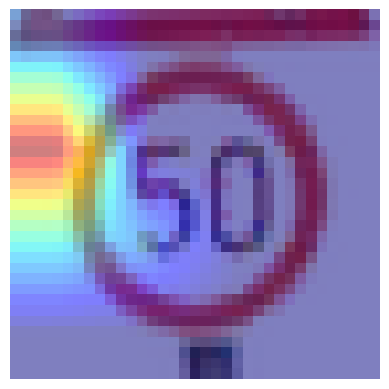

In [245]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import normalize
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

def grad_cam(model, input_image, target_class, layer_name):
    model.eval()  

    # Dictionary to hold gradients and activations
    gradients = {}
    activations = {}

    # Hook to capture gradients
    def backward_hook(module, grad_input, grad_output):
        gradients[layer_name] = grad_output[0]

    # Hook to capture activations
    def forward_hook(module, input, output):
        activations[layer_name] = output

    # Register hooks on the desired layer
    layer = dict(model.named_modules())[layer_name]
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    # Forward pass
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    input_image = input_image.to(next(model.parameters()).device)  # Move to device
    output = model(input_image)

    # Backward pass for the target class
    model.zero_grad()
    target_score = output[0, target_class]
    target_score.backward()

    # Compute Grad-CAM
    grads = gradients[layer_name]  # Gradients from backward pass
    acts = activations[layer_name]  # Activations from forward pass
    pooled_grads = torch.mean(grads, dim=(2, 3))  # Global average pooling

    # Weight activations by pooled gradients
    acts = acts * pooled_grads.view(1, -1, 1, 1)  # Apply broadcasting

    # Average across the channels
    heatmap = torch.mean(acts, dim=1).squeeze().detach().cpu().numpy()

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


# Visualisierung der Grad-CAM
def show_grad_cam(image, heatmap, alpha=0.5):
    # Normalize image to [0, 1]
    image = (image - image.min()) / (image.max() - image.min())

    # Resize heatmap to match image dimensions using PyTorch
    heatmap_tensor = torch.tensor(heatmap).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    heatmap_resized = F.interpolate(heatmap_tensor, size=image.shape[:2], mode='bilinear', align_corners=False)
    heatmap_resized = heatmap_resized.squeeze().numpy()  # Remove added dims
    heatmap_resized = np.uint8(255 * heatmap_resized)  # Scale heatmap to [0, 255]

    # Convert heatmap to RGB
    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]  # Convert heatmap to RGB
    heatmap_colored = heatmap_colored / np.max(heatmap_colored)  # Normalize heatmap

    # Combine heatmap with original image
    overlay = alpha * heatmap_colored + (1 - alpha) * image
    overlay = overlay / np.max(overlay)  # Normalize overlay to [0, 1]

    # Plot the result
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


# Lade und transformiere ein Bild von einem Pfad
def load_image(image_path, input_size=(3, 35, 35)):
    transform = transforms.Compose([
        transforms.Resize((input_size[1], input_size[2])),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    original_image = np.array(image) / 255.0  
    image_tensor = transform(image)
    return image_tensor, original_image


image_tensor, original_image = load_image(image_path)

# Zielklasse und Schicht
layer_name = "conv_layer5" 
target_class = 4

heatmap = grad_cam(trained_model, image_tensor, target_class, layer_name)
show_grad_cam(original_image, heatmap)


### LIME

100%|██████████| 1000/1000 [00:01<00:00, 639.96it/s]


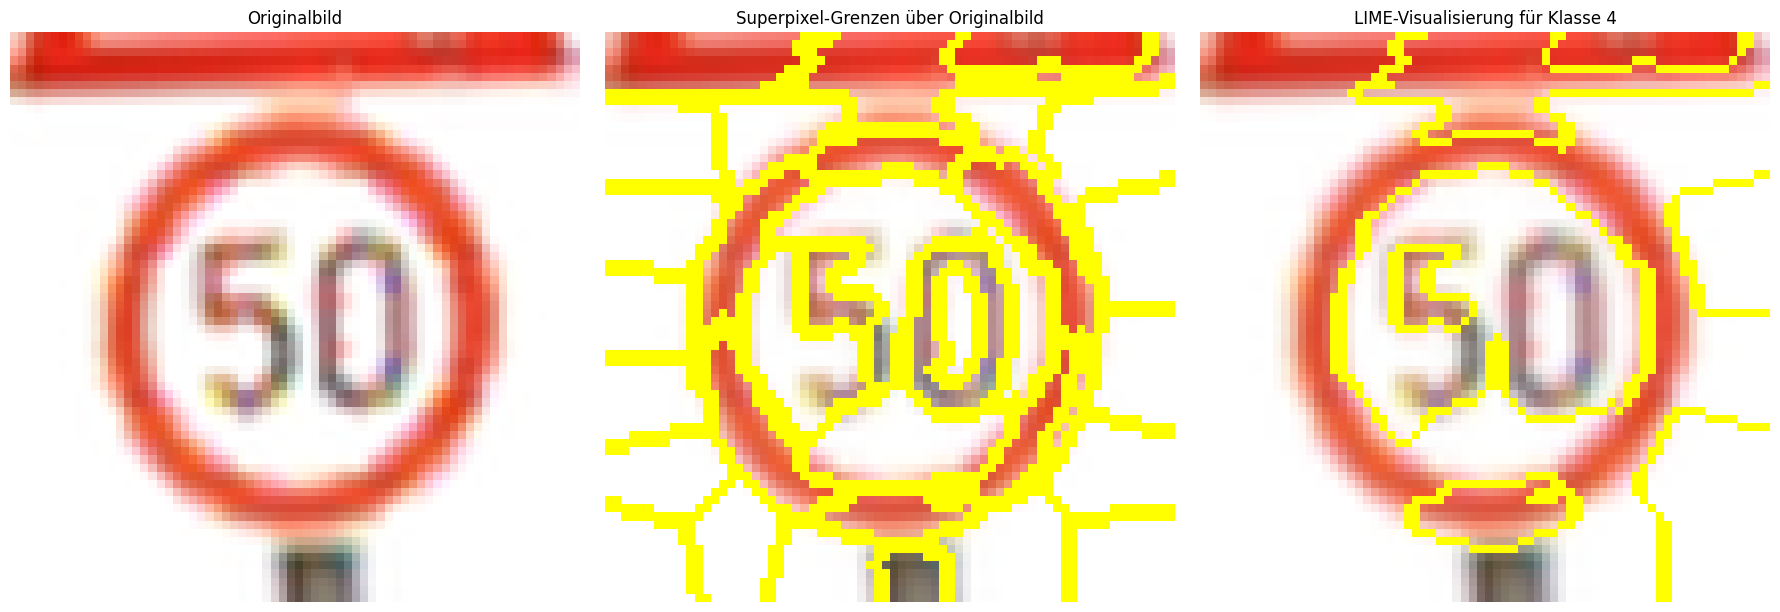

In [244]:
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries, slic
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np
from PIL import Image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def transform_image_for_model(image):
    """
    Transformiert das Bild zur Modell-Eingabegröße.
    """
    transform = transforms.Compose([
        transforms.Resize((70, 70)),  # Bild bleibt bei 70x70 für LIME
    ])
    return transform(image)

def predict_proba(images):
    """
    Wrapper-Funktion für LIME, um Modellvorhersagen für eine Reihe von Bildern zu generieren.
    """
    # Transformiert Bilder zurück auf 35x35 für das Modell
    transform = transforms.Compose([
        transforms.Resize((35, 35)),
        transforms.ToTensor()
    ])
    images_tensor = torch.stack([
        transform(Image.fromarray((image * 255).astype(np.uint8))).to(device) for image in images
    ])
    with torch.no_grad():
        outputs = trained_model(images_tensor)
        probs = torch.softmax(outputs, dim=1)
    return probs.cpu().numpy()

# Initialisierung des LIME-Explainers
explainer = LimeImageExplainer()
# Bildpfad

# Laden und Anpassen des Bildes auf 70x70 für LIME
example_image = Image.open(image_path).convert('RGB')
transformed_image = transform_image_for_model(example_image)
transformed_image_np = np.array(transformed_image) / 255.0  # Normalisierung auf [0, 1]

def custom_segmentation(image):
    """
    Angepasste Segmentierungsmethode für LIME.
    """
    return slic(image, n_segments=50, compactness=10, start_label=1)

# Generierung der LIME-Erklärung
explanation = explainer.explain_instance(
    transformed_image_np,
    predict_proba,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=custom_segmentation
)
# Visualisierung
label_to_explain = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.01
)

segments = slic(transformed_image_np, n_segments=50, compactness=10, start_label=1)
boundaries_image = mark_boundaries(transformed_image_np, segments)

plt.figure(figsize=(18, 6))

# Originalbild
plt.subplot(1, 3, 1)
plt.imshow(example_image.resize((70, 70)))
plt.title("Originalbild")
plt.axis("off")

# Superpixel-Grenzen über Originalbild
plt.subplot(1, 3, 2)
plt.imshow(boundaries_image)
plt.title("Superpixel-Grenzen über Originalbild")
plt.axis("off")
# LIME-Visualisierung
plt.subplot(1, 3, 3)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME-Visualisierung für Klasse {label_to_explain}")
plt.axis("off")

plt.tight_layout()
plt.show()


### Test

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# Neuron auswählen
target_neuron = 1  # Index des gewünschten Neurons (z. B. in der letzten Fully Connected Layer)
print(train_dataset.classes[target_neuron])

# Zufälliges Startbild erzeugen
input_image = torch.randn(1, 3, 35, 35, requires_grad=True, device=device)  # Für 32x32 RGB-Bilder

# Anzahl der Klassen in Ihrem Modell
num_classes = 43  # Passen Sie dies an, falls notwendig

# Eingabegröße Ihres Modells
input_size = (1, 3, 35, 35)  # Passen Sie die Größe an Ihr Modell an

# Ordner erstellen, um die Bilder zu speichern
os.makedirs('max_class_images', exist_ok=True)

# Für jede Klasse ein Bild generieren
for class_idx in range(num_classes):
    # Erstellen Sie ein zufälliges Eingabebild mit Gradienten
    input_image = torch.randn(input_size, requires_grad=True, device=device)
    
    # Definieren Sie den Optimierer
    optimizer = optim.Adam([input_image], lr=0.1)
    
    # Hauptoptimierungsschleife
    num_iterations = 100
    for i in range(num_iterations):
        optimizer.zero_grad()
        output = trained_model(input_image)
        # Die Ausgabe ist der Logit für jede Klasse
        class_score = output[0, class_idx]
        # Wir wollen den Klassenscore maximieren
        loss = -class_score
        loss.backward()
        optimizer.step()
        # Eingabebildwerte beschränken
        input_image.data.clamp_(0, 1)
        if i % 10 == 0:
            print(f'Klasse {class_idx}, Iteration {i}/{num_iterations}, Verlust: {loss.item()}')
    
    # Ergebnis visualisieren
    result = input_image.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    # Normalisieren Sie das Bild für die Darstellung
    result = (result - result.min()) / (result.max() - result.min())
    
    plt.imshow(result)
    plt.axis('off')
    plt.title(f'Klasse {class_idx}')
    plt.show()
    
    # Bild speichern
    plt.imsave(f'max_class_images/klasse_{class_idx}.png', result)


In [188]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Stellen Sie sicher, dass Ihr Modell im Evaluationsmodus ist
trained_model.eval()

# Gerät konfigurieren (CPU oder GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model.to(device)

# Transformationen definieren, die auf das Bild angewendet werden
transform = transforms.Compose([
    transforms.Resize((35, 35)),  # Passen Sie die Größe an die des Modells an
    transforms.ToTensor(),        # Konvertieren Sie das Bild in einen Tensor
    # Optional: Normalisierung hinzufügen, falls Ihr Modell dies erfordert
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

# Optional: Liste der Klassennamen definieren
class_names = [
    'Geschwindigkeitsbegrenzung (20km/h)',
    'Geschwindigkeitsbegrenzung (30km/h)',
    'Geschwindigkeitsbegrenzung (50km/h)',
    # ... fügen Sie alle 43 Klassennamen hinzu
    'Andere Gefahren'
]

def predict_image_class(image_path):
    """
    Lädt ein Bild, transformiert es und gibt die Wahrscheinlichkeiten der Top-3-Klassen zurück.
    """
    # Bild laden
    image = Image.open(image_path).convert('RGB')
    
    # Bild transformieren
    image_tensor = transform(image).unsqueeze(0).to(device)  # Batch-Dimension hinzufügen
    
    # Vorhersage durchführen
    with torch.no_grad():
        output = trained_model(image_tensor)
        # Wahrscheinlichkeiten berechnen
        probabilities = torch.softmax(output, dim=1)
        # Top-3-Klassen und -Wahrscheinlichkeiten erhalten
        top_probs, top_indices = torch.topk(probabilities, 3)
        top_probs = top_probs.cpu().numpy()[0]
        top_indices = top_indices.cpu().numpy()[0]
    
    # Ergebnisse als Liste von Tupeln (Klassenindex, Wahrscheinlichkeit) zurückgeben
    top_classes = [(int(idx), float(prob)) for idx, prob in zip(top_indices, top_probs)]
    return top_classes

# Beispielverwendung
image_path = 'output.png'  # Geben Sie den Pfad zu Ihrem Bild an
top_classes = predict_image_class(image_path)

# Ergebnisse ausgeben
print('Die Top-3-Klassen sind:')
for idx, prob in top_classes:
    if idx < len(class_names):
        class_name = class_names[idx]
    else:
        class_name = f'Klasse {idx}'
    print(f'{class_name}: {prob * 100:.2f}% Wahrscheinlichkeit')


Die Top-3-Klassen sind:
Klasse 35: 57.68% Wahrscheinlichkeit
Klasse 34: 14.20% Wahrscheinlichkeit
Klasse 19: 12.36% Wahrscheinlichkeit


### More

Die 3 stärksten aktivierten Neuronen in fc9:
1. Neuron 35: Aktivierung = 2.3502
2. Neuron 34: Aktivierung = 0.3984
3. Neuron 42: Aktivierung = 0.1119


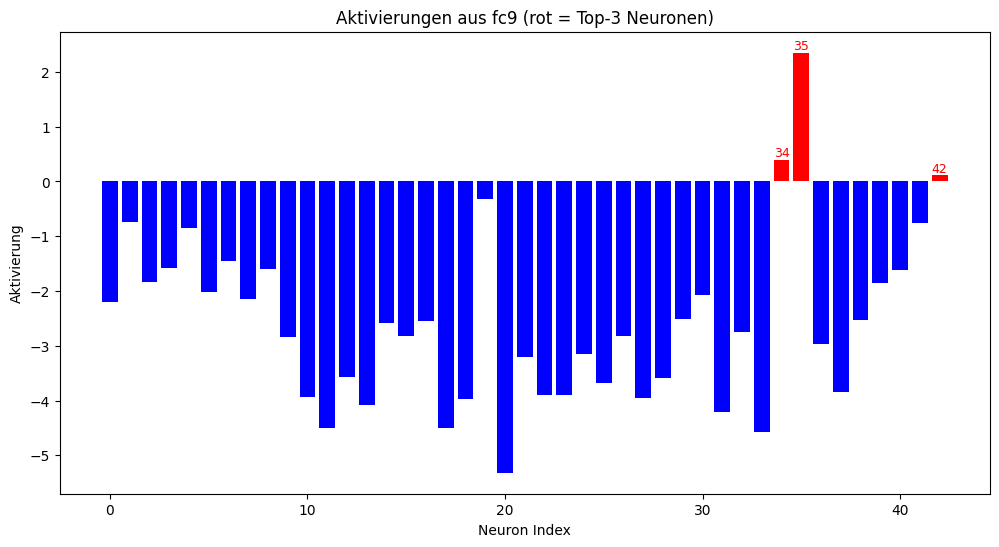

In [234]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_fc_layer_with_path_and_top_neurons(model, layer_name, image_path, top_n=5):
    model.eval()
    activations = {}

    # Hook für das gewünschte Layer
    def hook_fn(module, input, output):
        activations[layer_name] = output

    # Layer abrufen und Hook setzen
    target_layer = dict(model.named_modules())[layer_name]
    target_layer.register_forward_hook(hook_fn)

    # Bild laden und transformieren
    transform = transforms.Compose([
        transforms.Resize((35, 35)),  
        transforms.ToTensor(),      
    ])
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(next(model.parameters()).device)  # Auf Batch-Dimension erweitern

    # Bild durch das Modell schicken
    with torch.no_grad():
        model(input_image)

    features = activations[layer_name][0].cpu().detach().numpy()

    top_indices = np.argsort(features)[-top_n:][::-1]  
    top_activations = features[top_indices]  

    print(f"Die {top_n} stärksten aktivierten Neuronen in {layer_name}:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. Neuron {idx}: Aktivierung = {top_activations[i]:.4f}")

    plt.figure(figsize=(12, 6))
    colors = ['red' if i in top_indices else 'blue' for i in range(len(features))]
    plt.bar(range(len(features)), features, color=colors)
    plt.title(f'Aktivierungen aus {layer_name} (rot = Top-{top_n} Neuronen)')
    plt.xlabel('Neuron Index')
    plt.ylabel('Aktivierung')

    for i, idx in enumerate(top_indices):
        plt.text(idx, features[idx], f"{idx}", ha='center', va='bottom', fontsize=9, color='red')

    plt.show()
 
visualize_fc_layer_with_path_and_top_neurons(trained_model, 'fc9', image_path, top_n=3)
